Step 1.1: Set Up Libraries and APIs

In [22]:
# Import libraries
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set API key (replace 'YOUR_API_KEY' with your actual key)
ALPHA_VANTAGE_API_KEY = 'QYLTM9QOV6UBPYQW'


Step 1.2: Retrieve Historical Price Data

In [23]:
# Function to fetch historical price data for a single stock
def fetch_stock_data(symbol, interval='daily', outputsize='full'):
    """
    Fetch historical stock price data using Alpha Vantage API.
    
    :param symbol: Stock ticker symbol
    :param interval: Time interval ('daily', 'weekly', 'monthly')
    :param outputsize: Amount of data ('full' for all available, 'compact' for last 100 data points)
    :return: Pandas DataFrame containing historical price data
    """
    ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
    try:
        if interval == 'daily':
            data, _ = ts.get_daily(symbol=symbol, outputsize=outputsize)
        elif interval == 'weekly':
            data, _ = ts.get_weekly(symbol=symbol)
        elif interval == 'monthly':
            data, _ = ts.get_monthly(symbol=symbol)
        else:
            raise ValueError("Invalid interval. Choose from 'daily', 'weekly', or 'monthly'.")

        # Rename columns for clarity
        data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        data.index = pd.to_datetime(data.index)
        return data

    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# Example: Fetch data for Reliance Industries (ticker symbol 'RELIANCE.BSE')
symbol = 'RELIANCE.BSE'
reliance_data = fetch_stock_data(symbol)
if reliance_data is not None:
    print(reliance_data.head())  # Display the first few rows of data


              Open     High      Low    Close     Volume
date                                                    
2025-01-17  1325.1  1325.10  1284.70  1301.30  1514067.0
2025-01-16  1260.2  1275.00  1251.40  1268.70   391749.0
2025-01-15  1247.0  1256.75  1242.15  1252.30   287139.0
2025-01-14  1240.0  1255.05  1227.30  1238.55   837785.0
2025-01-13  1230.0  1245.15  1225.60  1240.05   810470.0


Step 1.3: Fetch Data for Multiple Stocks

In [24]:
# List of ticker symbols for NIFTY 50 or NIFTY 100 stocks
nifty_symbols = [
    'RELIANCE.BSE',  # Example symbol for Reliance Industries
    'TCS.BSE',       # Example symbol for TCS
    'INFY.BSE'       # Example symbol for Infosys
    # Add more symbols as needed
]

# Fetch data for all symbols and store in a dictionary
stock_data = {}
for symbol in nifty_symbols:
    print(f"Fetching data for {symbol}...")
    data = fetch_stock_data(symbol)
    if data is not None:
        stock_data[symbol] = data
        print(f"Data fetched successfully for {symbol}")
    else:
        print(f"Skipping {symbol} due to an error.")

# Example: Accessing data for a specific stock
if 'RELIANCE.BSE' in stock_data:
    reliance_data = stock_data['RELIANCE.BSE']
    print(reliance_data.tail())  # Display the last few rows


Fetching data for RELIANCE.BSE...
Data fetched successfully for RELIANCE.BSE
Fetching data for TCS.BSE...
Data fetched successfully for TCS.BSE
Fetching data for INFY.BSE...
Data fetched successfully for INFY.BSE
                Open      High       Low     Close      Volume
date                                                          
2005-01-07  359.8268  373.1158  359.5200  368.5838  33939690.0
2005-01-06  357.7824  365.6194  356.1470  358.4298  26893035.0
2005-01-05  358.1232  363.9158  351.8194  361.1214  33908532.0
2005-01-04  364.5974  371.3782  360.8490  361.7348  20119886.0
2005-01-03  354.4090  371.0712  354.4090  370.1174  23685843.0


Step 1.4: Save and Organize the Data.

In [26]:
# Save each stock's data as a separate CSV file
import os as os
def save_data_to_csv(stock_data, folder="stock_data"):
    """
    Save historical stock data to CSV files.
    
    :param stock_data: Dictionary with stock ticker symbols as keys and DataFrames as values
    :param folder: Folder name where CSV files will be saved
    """
    import os
    os.makedirs(folder, exist_ok=True)  # Create folder if it doesn't exist
    for symbol, data in stock_data.items():
        file_path = os.path.join(folder, f"{symbol}.csv")
        data.to_csv(file_path)
        print(f"Saved {symbol} data to {file_path}")

# Save the data
save_data_to_csv(stock_data)

# Optionally, reload data from CSV files
def load_data_from_csv(folder="stock_data"):
    """
    Load historical stock data from CSV files.
    
    :param folder: Folder containing the CSV files
    :return: Dictionary with stock ticker symbols as keys and DataFrames as values
    """
    loaded_data = {}
    for file in os.listdir(folder):
        if file.endswith(".csv"):
            symbol = file.replace(".csv", "")
            file_path = os.path.join(folder, file)
            loaded_data[symbol] = pd.read_csv(file_path, index_col=0, parse_dates=True)
            print(f"Loaded {symbol} data from {file_path}")
    return loaded_data

# Example: Reload the saved data
reloaded_data = load_data_from_csv()


Saved RELIANCE.BSE data to stock_data/RELIANCE.BSE.csv
Saved TCS.BSE data to stock_data/TCS.BSE.csv
Saved INFY.BSE data to stock_data/INFY.BSE.csv
Loaded INFY.BSE data from stock_data/INFY.BSE.csv
Loaded TCS.BSE data from stock_data/TCS.BSE.csv
Loaded RELIANCE.BSE data from stock_data/RELIANCE.BSE.csv


2.1: Simple and Exponential Moving Averages

In [36]:
# Generalized function to calculate all metrics for all stocks
def calculate_technical_indicators(stock_data_dict, sma_windows=[20, 50, 200], rsi_window=14):
    """
    Calculate SMA, EMA, and RSI for all stocks in the dataset.
    
    :param stock_data_dict: Dictionary with stock ticker symbols as keys and DataFrames as values
    :param sma_windows: List of window sizes for SMA and EMA
    :param rsi_window: Window size for RSI calculation
    :return: Dictionary with updated DataFrames for each stock
    """
    updated_data = {}
    for symbol, data in stock_data_dict.items():
        # Calculate SMA and EMA
        for window in sma_windows:
            data[f"SMA_{window}"] = data['Close'].rolling(window=window).mean()
            data[f"EMA_{window}"] = data['Close'].ewm(span=window, adjust=False).mean()
        
        # Calculate RSI
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=rsi_window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_window).mean()
        rs = gain / loss
        data['RSI'] = 100 - (100 / (1 + rs))
        
        # Add the updated DataFrame to the dictionary
        updated_data[symbol] = data
        
        # Print the metrics for the current stock
        print(f"Metrics for {symbol}:")
        print(data[['Close', 'SMA_20', 'EMA_20', 'RSI']].tail())
        print("\n")
    
    return updated_data

# Apply the function to all stocks
updated_stock_data = calculate_technical_indicators(reloaded_data)

# Example: Verify metrics for one stock (RELIANCE.BSE)
reliance_data = updated_stock_data['RELIANCE.BSE']
print(reliance_data[['Close', 'SMA_20', 'EMA_20', 'RSI']].tail())


Metrics for INFY.BSE:
              Close    SMA_20     EMA_20        RSI
date                                               
2005-01-07  32.0454  31.21619  31.352121  48.401392
2005-01-06  31.9242  31.22701  31.406605  50.401502
2005-01-05  32.0602  31.20447  31.468852  62.187694
2005-01-04  32.6306  31.19283  31.579495  71.577497
2005-01-03  33.0836  31.23251  31.722743  74.880062


Metrics for TCS.BSE:
               Close     SMA_20      EMA_20        RSI
date                                                  
2005-01-07  167.4250  160.76758  162.735404  59.089613
2005-01-06  164.9876  160.82258  162.949899  56.785670
2005-01-05  165.6000  160.93664  163.202290  74.178216
2005-01-04  167.5438  161.12851  163.615767  78.226337
2005-01-03  169.1500  161.42569  164.142837  86.128418


Metrics for RELIANCE.BSE:
               Close     SMA_20      EMA_20        RSI
date                                                  
2005-01-07  368.5838  356.16045  358.118026  55.235964
2005-01-06  3

Function to Fetch and Calculate Fundamental Metrics:


In [38]:
def fetch_fundamental_metrics(stock_symbol):
    """
    Fetch and calculate key fundamental metrics for a given stock symbol.
    
    :param stock_symbol: The stock ticker symbol (e.g., 'INFY.BSE')
    :return: Dictionary containing fundamental metrics
    """
    # Fetch stock data from Yahoo Finance
    stock_data = yf.Ticker(stock_symbol)
    
    # Get the stock's price and financial data
    try:
        # Fetch historical data for price
        price_data = stock_data.history(period="1d", start="2005-01-01", end="2025-01-01")
        latest_price = price_data['Close'].iloc[-1]
        
        # Fetch company info and financials
        info = stock_data.info
        pe_ratio = info.get('trailingPE', None)
        pb_ratio = info.get('priceToBook', None)
        dividend_yield = info.get('dividendYield', None)
        eps = info.get('trailingEps', None)
        roe = info.get('returnOnEquity', None)
        
        # Prepare metrics
        metrics = {
            "Latest Price": latest_price,
            "P/E Ratio": pe_ratio,
            "P/B Ratio": pb_ratio,
            "Dividend Yield": dividend_yield,
            "EPS": eps,
            "ROE": roe
        }
        
        return metrics
    except Exception as e:
        print(f"Error fetching data for {stock_symbol}: {e}")
        return None

# Example: Fetch metrics for INFY.BSE, TCS.BSE, and RELIANCE.BSE
stock_symbols = ['INFY.NS', 'TCS.NS', 'RELIANCE.NS']

metrics_dict = {}

for symbol in stock_symbols:
    metrics = fetch_fundamental_metrics(symbol)
    if metrics:
        metrics_dict[symbol] = metrics

# Convert the metrics dictionary to a DataFrame for easier viewing
metrics_df = pd.DataFrame(metrics_dict).T
print(metrics_df)


             Latest Price  P/E Ratio   P/B Ratio  Dividend Yield     EPS  \
INFY.NS       1880.000000  26.472311  708.349600          0.0213   68.26   
TCS.NS        4085.065186  30.283628   16.329538          0.0097  134.86   
RELIANCE.NS   1215.449951  25.581282    2.232706          0.0040   51.18   

                 ROE  
INFY.NS      0.31404  
TCS.NS       0.46772  
RELIANCE.NS  0.08479  


MACD Calculation and Candlestick Chart Comparison

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Function to calculate MACD and Signal Line
def calculate_macd(data, fast_window=12, slow_window=26, signal_window=9):
    data['EMA_12'] = data['Close'].ewm(span=fast_window, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=slow_window, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']
    return data

# Function to plot candlestick chart for comparison
def plot_candlestick(stock_data, stock_name):
    mpf.plot(stock_data, type='candle', title=stock_name, style='charles',
             ylabel='Price', ylabel_lower='Volume', figsize=(10, 6))
    
# Assuming you have your stock data loaded in updated_stock_data
# Apply MACD calculation to the stock data
for symbol, data in updated_stock_data.items():
    print(updated_stock_data.keys())
    updated_stock_data[symbol] = calculate_macd(data)

# Plotting the candlestick charts and comparing them
for idx, symbol in enumerate(['INFY.BSE', 'TCS.BSE', 'RELIANCE.BSE']):
    ax = axs[idx]
    stock_data = updated_stock_data[symbol].copy()

    # Ensure the stock data contains 'Open', 'High', 'Low', 'Close' columns
    stock_data = stock_data[['Open', 'High', 'Low', 'Close']]

    # Plot using mpf.plot with the figure and axis set properly
    mpf.plot(stock_data, type='candle', ax=ax, title=symbol, style='charles', show_nontrading=False, warn_too_much_data=2000)

plt.tight_layout()
plt.show()

# Show MACD values for comparison (optional)
for symbol, data in updated_stock_data.items():
    print(f"MACD and Signal Line for {symbol}:")
    print(data[['Close', 'MACD', 'Signal_Line', 'MACD_Histogram']].tail(), "\n")


dict_keys(['INFY.BSE', 'TCS.BSE', 'RELIANCE.BSE'])
dict_keys(['INFY.BSE', 'TCS.BSE', 'RELIANCE.BSE'])
dict_keys(['INFY.BSE', 'TCS.BSE', 'RELIANCE.BSE'])


/Users/jatinkushwaha/anaconda3/envs/venv-metal/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


AttributeError: 'NoneType' object has no attribute 'suptitle'

/Users/jatinkushwaha/anaconda3/envs/venv-metal/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


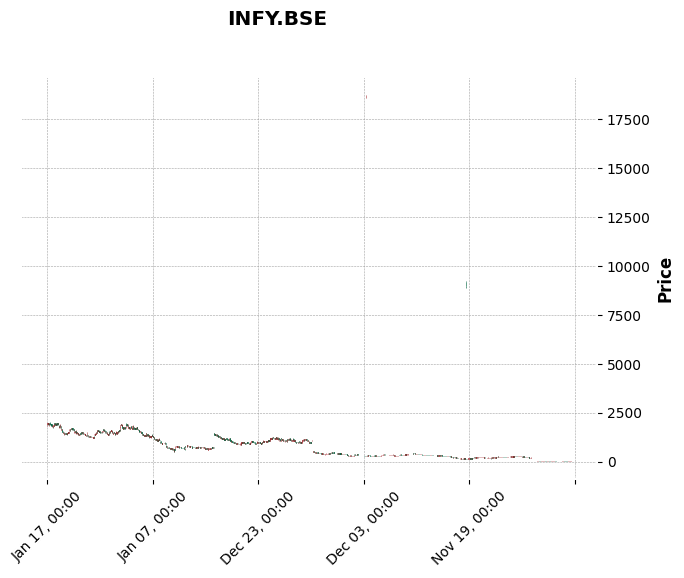

/Users/jatinkushwaha/anaconda3/envs/venv-metal/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


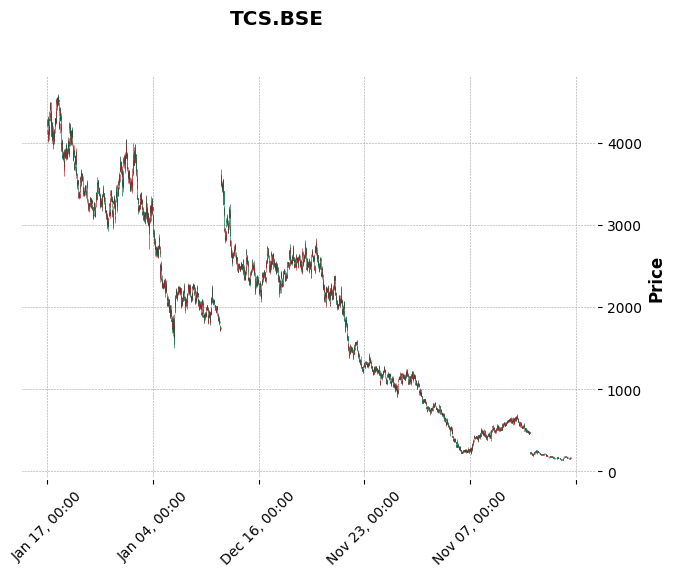

/Users/jatinkushwaha/anaconda3/envs/venv-metal/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


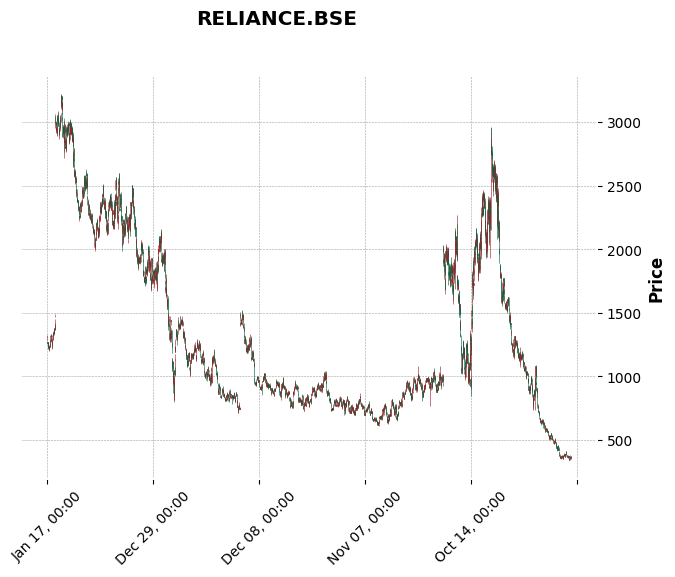

MACD and Signal Line for INFY.BSE:
              Close      MACD  Signal_Line  MACD_Histogram
date                                                      
2005-01-07  32.0454 -0.514875    -0.688182        0.173306
2005-01-06  31.9242 -0.408908    -0.632327        0.223419
2005-01-05  32.0602 -0.310375    -0.567936        0.257561
2005-01-04  32.6306 -0.184139    -0.491177        0.307038
2005-01-03  33.0836 -0.047000    -0.402342        0.355341 

MACD and Signal Line for TCS.BSE:
               Close      MACD  Signal_Line  MACD_Histogram
date                                                       
2005-01-07  167.4250 -0.908728    -2.380333        1.471604
2005-01-06  164.9876 -0.640608    -2.032388        1.391780
2005-01-05  165.6000 -0.374389    -1.700788        1.326399
2005-01-04  167.5438 -0.006485    -1.361927        1.355442
2005-01-03  169.1500  0.409962    -1.007550        1.417512 

MACD and Signal Line for RELIANCE.BSE:
               Close      MACD  Signal_Line  MACD_Histo

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Function to calculate MACD and Signal Line
def calculate_macd(data, fast_window=12, slow_window=26, signal_window=9):
    data['EMA_12'] = data['Close'].ewm(span=fast_window, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=slow_window, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']
    return data

# Assuming you have your stock data loaded in updated_stock_data
# Apply MACD calculation to the stock data
for symbol, data in updated_stock_data.items():
    updated_stock_data[symbol] = calculate_macd(data)

# Plotting the candlestick charts and comparing them
for symbol in ['INFY.BSE', 'TCS.BSE', 'RELIANCE.BSE']:
    stock_data = updated_stock_data[symbol].copy()

    # Ensure the stock data contains 'Open', 'High', 'Low', 'Close' columns
    stock_data = stock_data[['Open', 'High', 'Low', 'Close']]

    # Plot using mpf.plot
    mpf.plot(stock_data, type='candle', title=symbol, style='charles', 
             show_nontrading=False, warn_too_much_data=2000)

# Show MACD values for comparison (optional)
for symbol, data in updated_stock_data.items():
    print(f"MACD and Signal Line for {symbol}:")
    print(data[['Close', 'MACD', 'Signal_Line', 'MACD_Histogram']].tail(), "\n")


Rank the stocks

In [49]:

# Data for the stocks
data = {
    'Stock': ['INFY.NS', 'TCS.NS', 'RELIANCE.NS'],
    'P/E Ratio': [26.472311, 30.283628, 25.581282],
    'P/B Ratio': [708.349600, 16.329538, 2.232706],
    'Dividend Yield': [0.0213, 0.0097, 0.0040],
    'EPS': [68.26, 134.86, 51.18],
    'ROE': [0.31404, 0.46772, 0.08479]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Rank stocks for each metric (lower P/E and P/B, higher Dividend Yield, EPS, and ROE)
df['P/E Rank'] = df['P/E Ratio'].rank(ascending=True)
df['P/B Rank'] = df['P/B Ratio'].rank(ascending=True)
df['Dividend Yield Rank'] = df['Dividend Yield'].rank(ascending=False)
df['EPS Rank'] = df['EPS'].rank(ascending=False)
df['ROE Rank'] = df['ROE'].rank(ascending=False)

# Calculate the overall rank based on the sum of the individual ranks
df['Total Rank'] = df[['P/E Rank', 'P/B Rank', 'Dividend Yield Rank', 'EPS Rank', 'ROE Rank']].sum(axis=1)

# Sort by total rank (lower total rank is better)
df = df.sort_values('Total Rank')

# Display the ranked stocks
print(df[['Stock', 'Total Rank']])


         Stock  Total Rank
1       TCS.NS         9.0
0      INFY.NS        10.0
2  RELIANCE.NS        11.0


In [55]:
# Stock Selection for the Virtual Portfolio
# Assigning stock symbols (This can be customized based on your selection)
large_cap_stocks = ['INFY.NS', 'TCS.NS', 'RELIANCE.NS', 'HDFC.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'HUL.NS', 'M&M.NS']
mid_cap_stocks = ['TITAN.NS', 'BAJFINANCE.NS', 'BHARTIARTL.NS', 'MARUTI.NS', 'SBIN.NS']
small_cap_stocks = ['CAMLINFINE.NS', 'SYNGENE.NS']

# Portfolio Allocation (weights)
large_cap_weight = 0.60  # 60% for large-cap stocks
mid_cap_weight = 0.30    # 30% for mid-cap stocks
small_cap_weight = 0.10  # 10% for small-cap stocks

# Number of stocks in each category
num_large_cap = len(large_cap_stocks)
num_mid_cap = len(mid_cap_stocks)
num_small_cap = len(small_cap_stocks)

# Total number of stocks in portfolio
total_stocks = num_large_cap + num_mid_cap + num_small_cap

# Calculate weight per stock in each category
large_cap_per_stock = large_cap_weight / num_large_cap
mid_cap_per_stock = mid_cap_weight / num_mid_cap
small_cap_per_stock = small_cap_weight / num_small_cap

# Print Portfolio Allocation for Documentation
print("Virtual Portfolio Allocation:\n")
print(f"Large-Cap Stocks: {num_large_cap} stocks, Weight per stock: {large_cap_per_stock*100}%")
print(f"Mid-Cap Stocks: {num_mid_cap} stocks, Weight per stock: {mid_cap_per_stock*100}%")
print(f"Small-Cap Stocks: {num_small_cap} stocks, Weight per stock: {small_cap_per_stock*100}%")

# Simulating the purchase of stocks on 20/01/2025 using their current price (Placeholder prices, replace with actual data)
current_prices = {
    'INFY.NS': 1812.90,
    'TCS.NS': 4094.20,
    'RELIANCE.NS': 1307.10,
    'HDFC.NS': 2729.95,
    'ICICIBANK.NS': 1229.65,
    'KOTAKBANK.NS': 1920.85,
    'HUL.NS': 2360.05,
    'M&M.NS': 2888.10,
    'TITAN.NS': 3382.25,
    'BAJFINANCE.NS': 7440.10,
    'BHARTIARTL.NS': 650.0,
    'MARUTI.NS': 12020.05,
    'SBIN.NS': 779.25,
    'CAMLINFINE.NS': 135.73,
    'SYNGENE.NS': 821.70
}

# Calculating the number of shares to buy for each stock based on available funds and weight allocation
portfolio = {}

# Total virtual money available (example: 10 million INR)
total_money = 10000000

# Allocate money to each category
money_large_cap = total_money * large_cap_weight
money_mid_cap = total_money * mid_cap_weight
money_small_cap = total_money * small_cap_weight

# Allocate funds to each stock
for stock in large_cap_stocks:
    portfolio[stock] = {'Amount': money_large_cap * large_cap_per_stock, 'Shares': money_large_cap * large_cap_per_stock / current_prices[stock]}

for stock in mid_cap_stocks:
    portfolio[stock] = {'Amount': money_mid_cap * mid_cap_per_stock, 'Shares': money_mid_cap * mid_cap_per_stock / current_prices[stock]}

for stock in small_cap_stocks:
    portfolio[stock] = {'Amount': money_small_cap * small_cap_per_stock, 'Shares': money_small_cap * small_cap_per_stock / current_prices[stock]}

# Print the portfolio allocation
print("\nPortfolio Stock Allocation (Number of shares per stock):\n")
for stock, info in portfolio.items():
    print(f"{stock}: {info['Shares']:.2f} shares, Amount allocated: ₹{info['Amount']:.2f}")

# You can further enhance the portfolio by including metrics and real-time market prices.


Virtual Portfolio Allocation:

Large-Cap Stocks: 8 stocks, Weight per stock: 7.5%
Mid-Cap Stocks: 5 stocks, Weight per stock: 6.0%
Small-Cap Stocks: 2 stocks, Weight per stock: 5.0%

Portfolio Stock Allocation (Number of shares per stock):

INFY.NS: 248.22 shares, Amount allocated: ₹450000.00
TCS.NS: 109.91 shares, Amount allocated: ₹450000.00
RELIANCE.NS: 344.27 shares, Amount allocated: ₹450000.00
HDFC.NS: 164.84 shares, Amount allocated: ₹450000.00
ICICIBANK.NS: 365.96 shares, Amount allocated: ₹450000.00
KOTAKBANK.NS: 234.27 shares, Amount allocated: ₹450000.00
HUL.NS: 190.67 shares, Amount allocated: ₹450000.00
M&M.NS: 155.81 shares, Amount allocated: ₹450000.00
TITAN.NS: 53.22 shares, Amount allocated: ₹180000.00
BAJFINANCE.NS: 24.19 shares, Amount allocated: ₹180000.00
BHARTIARTL.NS: 276.92 shares, Amount allocated: ₹180000.00
MARUTI.NS: 14.97 shares, Amount allocated: ₹180000.00
SBIN.NS: 230.99 shares, Amount allocated: ₹180000.00
CAMLINFINE.NS: 368.38 shares, Amount allocated:

prediction

[*********************100%***********************]  1 of 1 completed

Mean Squared Error (MSE): 105.18213452539088
Predicted closing price for next month: ₹1824.77


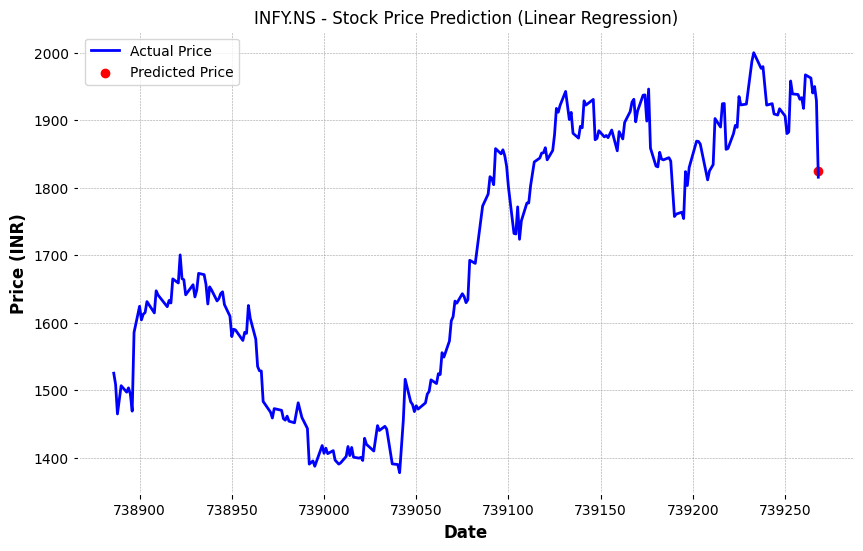

In [67]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import yfinance as yf

# Step 1: Download historical stock data for Stock A
# You can replace 'INFY.NS' with your desired stock symbol
stock_symbol = 'INFY.NS'
data = yf.download(stock_symbol, start="2024-01-01", end="2025-01-20")

# Step 2: Preprocessing the data
# Use 'Date' as index, and 'Close' for prediction
data['Date'] = data.index
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].map(lambda x: x.toordinal())  # Convert date to ordinal number for regression

# Select features (Date, Open, High, Low, Volume) and target (Close)
X = data[['Date', 'Open', 'High', 'Low', 'Volume']]  # Features
y = data['Close']  # Target: Close price

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize Linear Regression model and fit the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predictions on test data
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Step 6: Predict future price (next month)
# Predict the price for the next month based on the latest data point
latest_data = data.iloc[-1]
latest_data_input = np.array([[latest_data['Date'], latest_data['Open'], latest_data['High'], latest_data['Low'], latest_data['Volume']]])

# Ensure the input shape is 2D, i.e., one sample with multiple features
latest_data_input = latest_data_input.reshape(1, -1)

# Predict the next closing price
predicted_price = model.predict(latest_data_input)


# Extract the predicted price and format it correctly
# Extract the predicted price and format it correctly
predicted_price_value = predicted_price.item()  # item() will convert the numpy array to a scalar

print(f"Predicted closing price for next month: ₹{predicted_price_value:.2f}")



# Step 7: Plot the predictions
plt.figure(figsize=(10,6))
plt.plot(data['Date'], data['Close'], label='Actual Price', color='blue')
plt.scatter(latest_data['Date'], predicted_price, color='red', label='Predicted Price')
plt.title(f'{stock_symbol} - Stock Price Prediction (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()


In [78]:
import numpy as np
import pandas as pd
import yfinance as yf

# List of portfolio stocks (excluding failed ones)
portfolio_stocks = ['INFY.NS', 'TCS.NS', 'RELIANCE.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'M&M.NS', 'TITAN.NS', 'BAJFINANCE.NS', 'BHARTIARTL.NS', 'MARUTI.NS', 'SBIN.NS', 'CAMLINFINE.NS', 'SYNGENE.NS']

# Download stock data for each stock
stock_data = {}
for stock in portfolio_stocks:
    try:
        stock_data[stock] = yf.download(stock, start="2024-01-01", end="2025-01-20")
    except Exception as e:
        print(f"Failed to download {stock}: {str(e)}")

# Now calculate total returns, Sharpe ratio, and beta
returns = {}
for stock, data in stock_data.items():
    if data.empty:
        continue  # Skip if no data for the stock
    data['Returns'] = data['Close'].pct_change() * 100
    returns[stock] = data['Returns'].iloc[-1]  # Use the last return for prediction

# Calculate total portfolio return (assuming equal weights for each stock)
total_return = np.mean(list(returns.values())) if returns else np.nan

# Identify top-performing and underperforming stocks
top_stock = max(returns, key=returns.get)
underperforming_stock = min(returns, key=returns.get)

# Sharpe Ratio and Beta calculations (simplified)
# Assuming risk-free rate of 5% and market return (mean of stock returns)
risk_free_rate = 5
market_return = np.mean(list(returns.values())) if returns else 0

sharpe_ratio = (market_return - risk_free_rate) / np.std(list(returns.values())) if returns else np.nan

# For beta, assume we are comparing against the market (e.g., NIFTY 50 index, represented by "^NSEI")
market_data = yf.download('^NSEI', start="2024-01-01", end="2025-01-20")
market_returns = market_data['Close'].pct_change() * 100

beta = {}
for stock, data in stock_data.items():
    if data.empty:
        continue
    stock_returns = data['Close'].pct_change() * 100
    
    # Ensure there is enough data for covariance calculation
    if len(stock_returns) > 1 and not market_returns.empty and len(market_returns) > 1 and np.var(market_returns[1:].values) > 0:
        cov_matrix = np.cov(stock_returns[1:].values, market_returns[1:].values)
        beta_value = cov_matrix[0][1] / np.var(market_returns[1:].values)
        beta[stock] = beta_value
    else:
        beta[stock] = np.nan

# Print the results
print(f"Portfolio Total Return: {total_return:.2f}%")
print(f"Top Performing Stock: {top_stock} with {returns[top_stock]:.2f}% return")
print(f"Underperforming Stock: {underperforming_stock} with {returns[underperforming_stock]:.2f}% return")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/fv/rwpky7gd2qn02d52zh

Portfolio Total Return: -0.85%
Top Performing Stock: RELIANCE.NS with 2.83% return
Underperforming Stock: INFY.NS with -5.86% return
Sharpe Ratio: -2.90
